In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch.autograd import grad
import torchvision

torch.manual_seed(50)

In [2]:
interval = 30
class_num = 10
protected_layers = []  # No specific layers to protect initially
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:4"  # Changed to cuda:0 for general usage
print("Running on %s" % device)

Files already downloaded and verified
Running on cuda:4


In [3]:
def label_to_onehot(target, num_classes=class_num):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [4]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [5]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, class_num)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 2. 
Onehot label is 2.


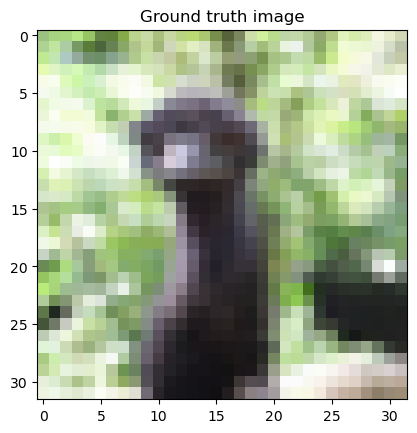

In [8]:
img_index = 55
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

In [9]:
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

In [11]:
torch.cat([g.view(-1) for g in dy_dx]).count_nonzero()

tensor(19438, device='cuda:4')

In [13]:
flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
flattened_grads[-5:]

tensor([6.1626e-04, 4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04],
       device='cuda:4')

In [14]:
flattened_grads[-4:]

tensor([4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04], device='cuda:4')

In [15]:
flattened_grads[-3:]

tensor([0.0004, 0.0019, 0.0009], device='cuda:4')

In [16]:
total_params = len(flattened_grads)
exposed_params = int(total_params * (1/2))

In [17]:
total_params

19438

In [18]:
exposed_params

9719

In [19]:
mask = torch.zeros(total_params, device=flattened_grads.device)

In [20]:
mask[:exposed_params] = 1

In [21]:
mask.count_nonzero()

tensor(9719, device='cuda:4')

In [22]:
#mask = mask[torch.randperm(total_params)]

In [22]:
def mask_gradients(dy_dx, exposure_ratio=1/3):
    flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
    total_params = len(flattened_grads)
    exposed_params = int(total_params * exposure_ratio)

    mask = torch.zeros(total_params, device=flattened_grads.device)
    mask[:exposed_params] = 1
    #mask = mask[torch.randperm(total_params)]

    masked_grads = []
    start = 0
    for g in dy_dx:
        numel = g.numel()
        g_flat = g.view(-1)
        masked_g_flat = g_flat * mask[start:start+numel]
        masked_grads.append(masked_g_flat.view_as(g))
        start += numel

    return tuple(masked_grads)

In [23]:
dy_dx = mask_gradients(dy_dx)

In [25]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 7.


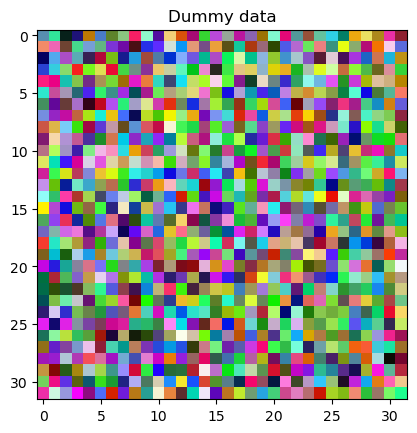

In [26]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Dummy label is 2.
0, 41.65907669067383
30, 5.346749305725098
60, 2.8736212253570557
90, 2.022608995437622
120, 1.5733850002288818
150, 1.2150163650512695
180, 0.9503500461578369
210, 0.772109866142273
240, 0.6428539752960205
270, 0.5329146981239319
300, 0.4441123604774475
330, 0.36549556255340576
360, 0.3032659888267517
390, 0.25349023938179016
420, 0.2153865545988083
450, 0.18442116677761078
480, 0.15677224099636078
510, 0.1304161250591278
540, 0.1102694422006607
570, 0.09286773949861526
600, 0.08159936964511871
630, 0.07274502515792847
660, 0.06483147293329239
690, 0.05816776305437088
720, 0.052252985537052155
750, 0.0471634715795517
780, 0.042750462889671326
810, 0.037908315658569336
840, 0.03411548584699631
870, 0.031139522790908813


<Figure size 1200x800 with 0 Axes>

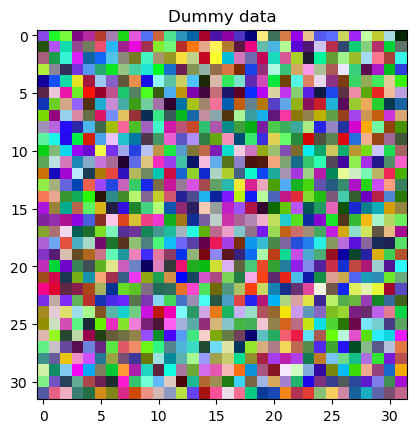

<Figure size 1200x800 with 0 Axes>

In [27]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

history = []
losses = []
for iters in range(30*interval):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        dummy_dy_dx = mask_gradients(dummy_dy_dx)

        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        grad_diff.backward()
        losses.append(grad_diff.item())
        return grad_diff

    optimizer.step(closure)
    if iters % interval == 0:
        print(f"{iters}, {losses[iters]}")
    history.append(tt(dummy_data[0].cpu()))

plt.figure(figsize=(12, 8))

In [28]:
history.__len__()

900

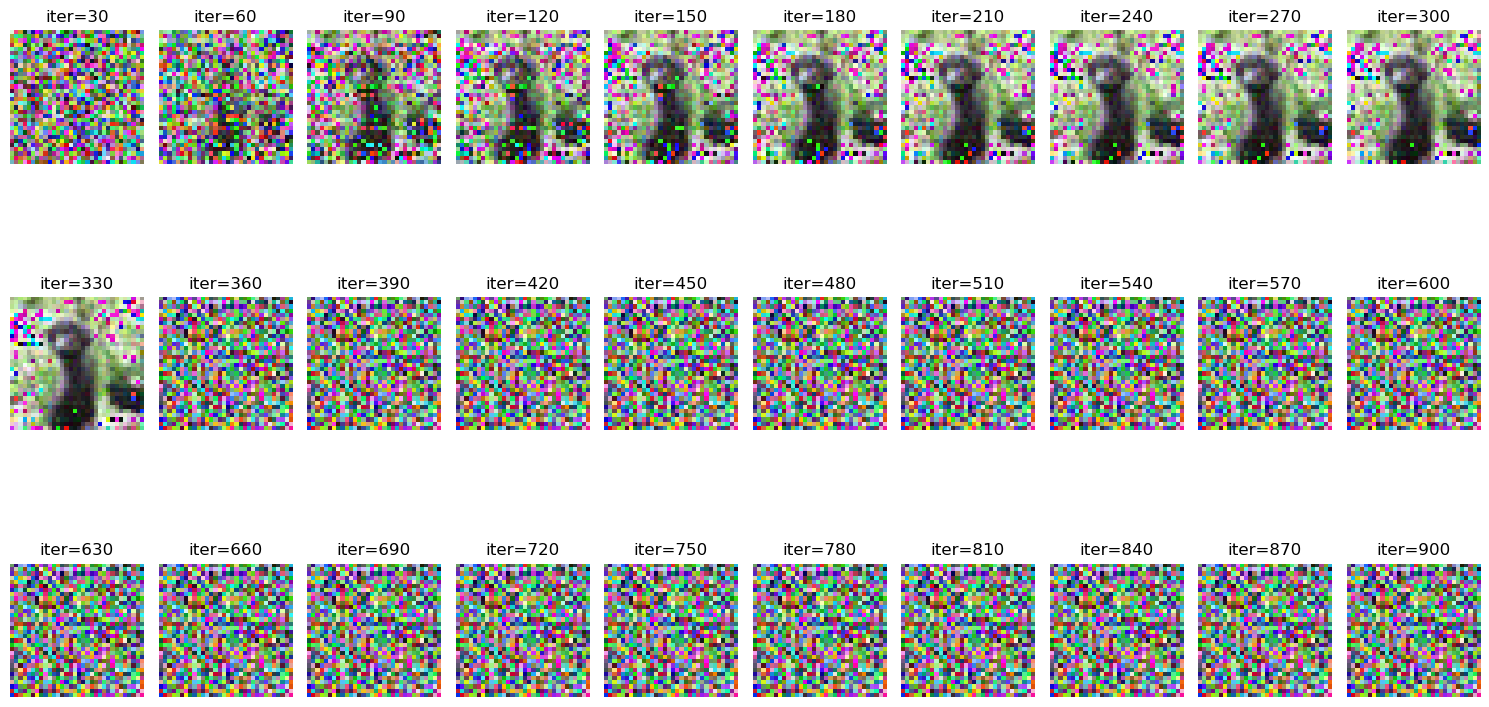

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: replace this with your actual image data
# For demonstration, let's generate 900 random images (28x28 pixels)
# history = np.random.rand(900, 28, 28)

# Set the interval
interval = 30

# Create a figure
plt.figure(figsize=(15, 9))

for i in range(30):
    ite_num = i * interval + interval - 1
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[ite_num])  # Assuming the images are grayscale
    plt.title("iter=%d" % (ite_num + 1))
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


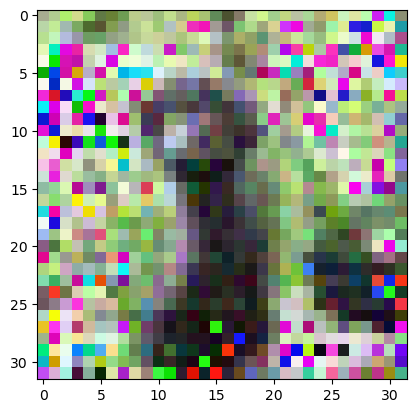

In [30]:
plt.imshow(history[209])
# plt.title("iter=%d" % (ite_num+1))
plt.show()

2.3.1 0.18.1
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 2.
0, 81.35954284667969
30, 7.255378723144531
60, 3.5717732906341553
90, 2.46608304977417


/home/dawitkr/miniconda3/envs/flwr-exp/lib/python3.9/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


120, 1.8977487087249756
150, 1.5943760871887207
180, 1.296427845954895
210, 1.0371514558792114
240, 0.8591431379318237
270, 0.699986457824707
300, 0.5454366207122803
330, 0.4381682872772217
360, 0.3487466275691986
390, 0.2732091248035431
420, 0.21715228259563446
450, 0.17458947002887726
480, 0.14211156964302063
510, 0.11737677454948425
540, 0.09635040163993835
570, 0.08290177583694458
600, 0.06917458027601242
630, 0.05874856188893318
660, 0.05089529603719711
690, 0.04426835477352142
720, 0.03968079760670662
750, 0.035752180963754654
780, 0.03201186656951904
810, 0.029075879603624344
840, 0.026691777631640434
870, 0.02415291965007782
idx = 898, len = 3078
Dummy label is 2.
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 9.
0, 81.68539428710938
30, 8.881128311157227
60, 4.570374011993408
90, 3.5188117027282715
120, 2.8113021850585938
150, 2.2181544303894043
180, 1.8510605096817017
210, 1.5359147787094116
240, 1.2657270431518555
27

/tmp/ipykernel_47676/2352204826.py:158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


idx = 898, len = 4315
Dummy label is 2.


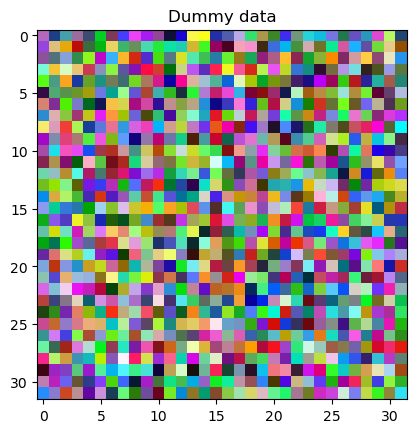

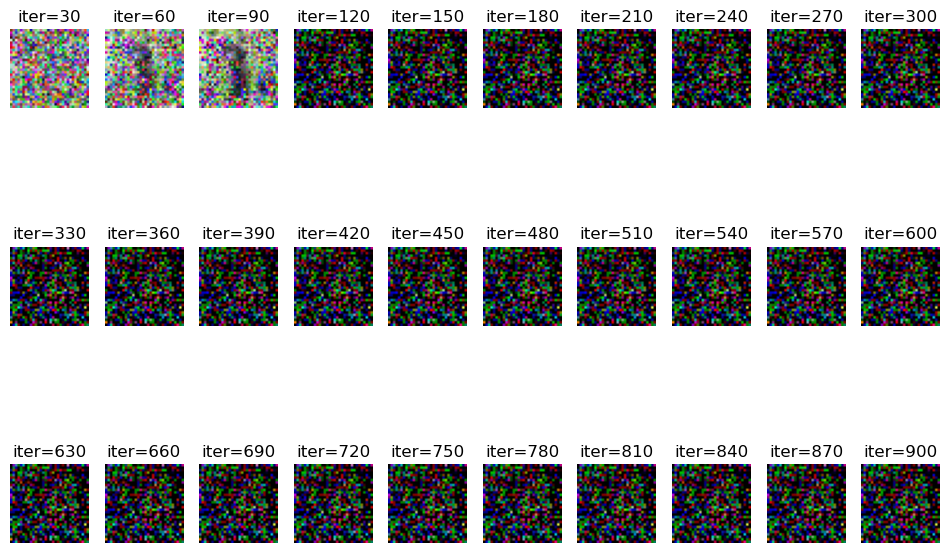

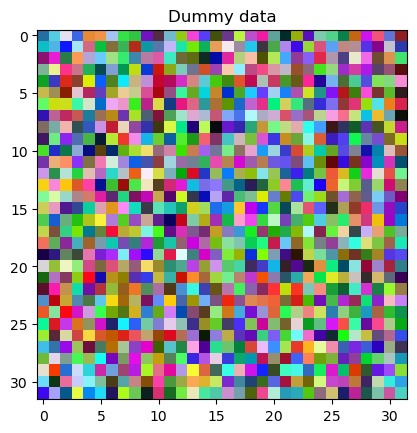

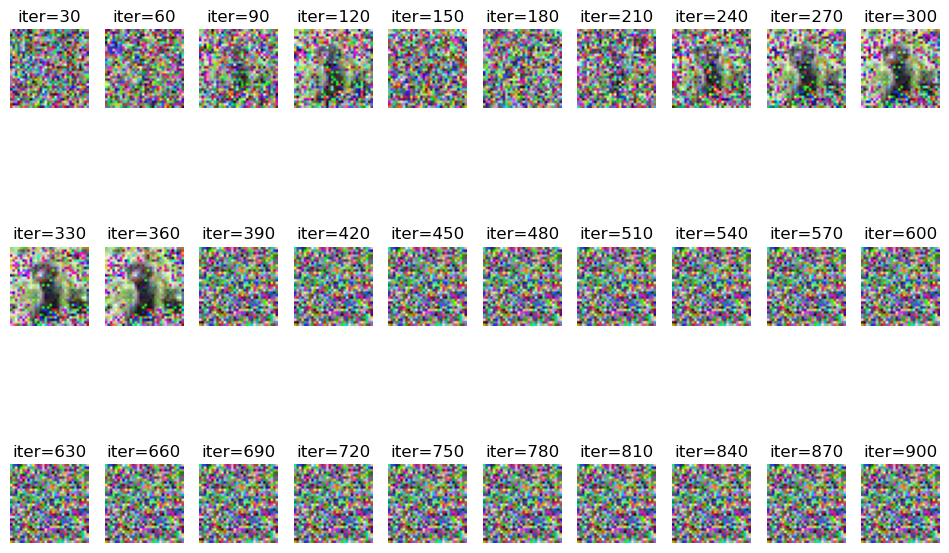

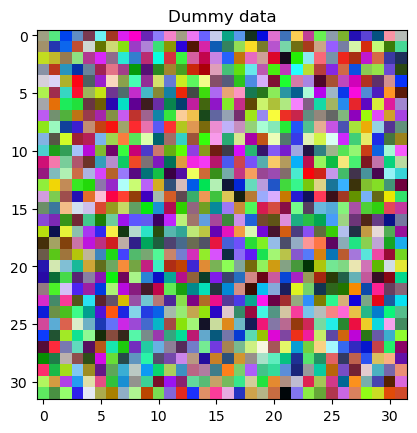

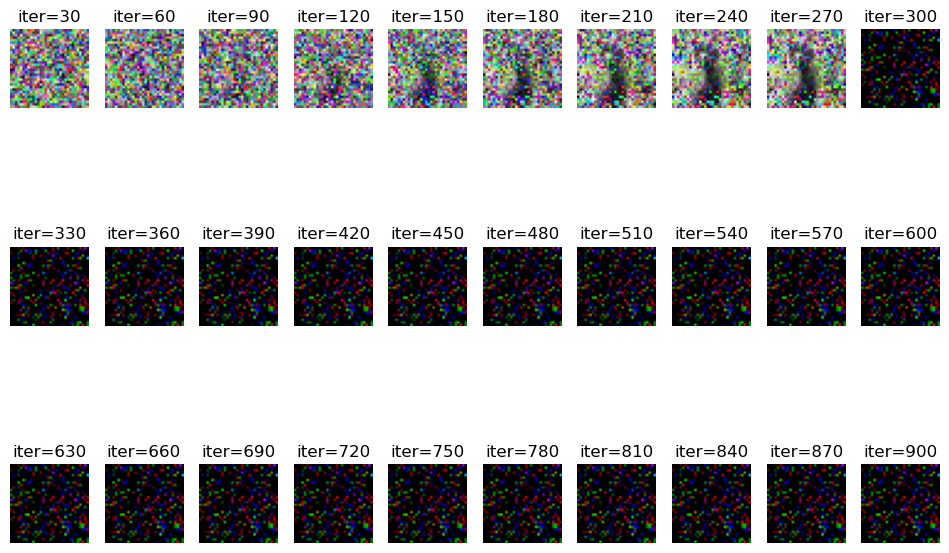

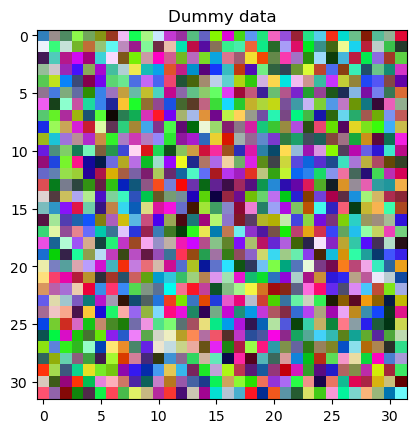

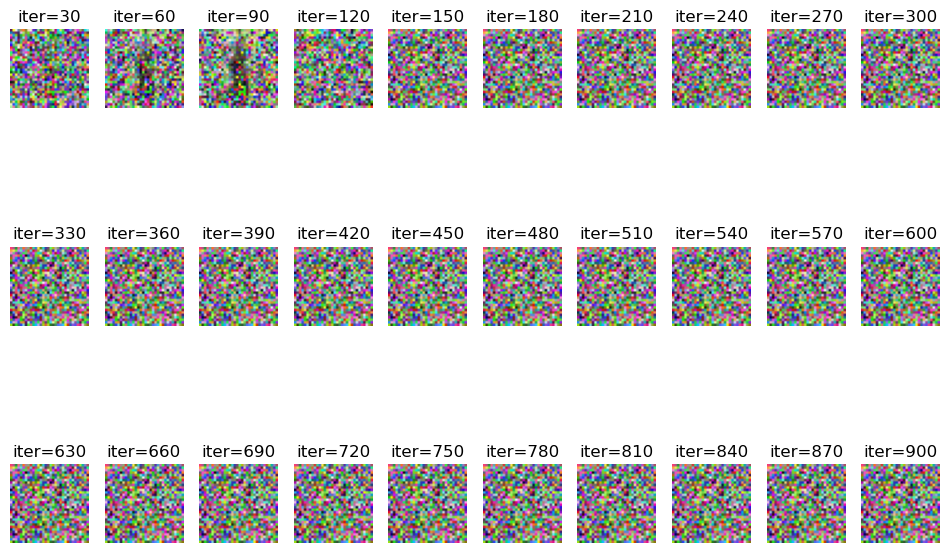

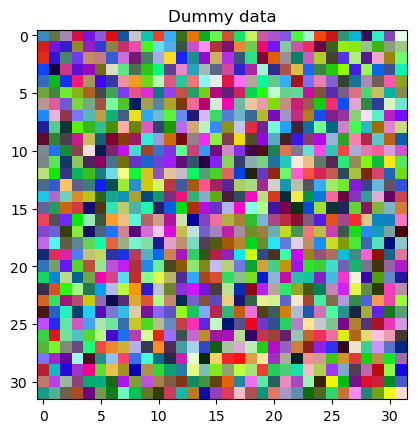

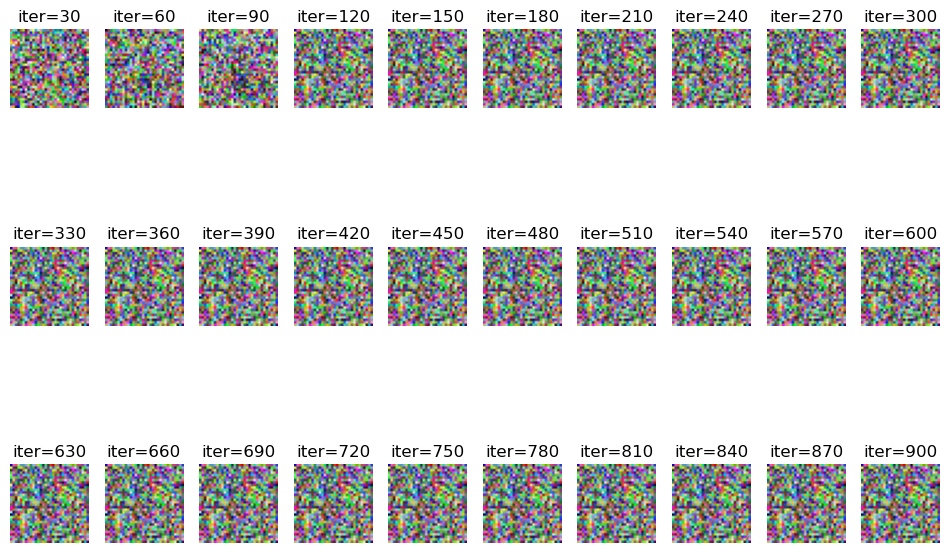

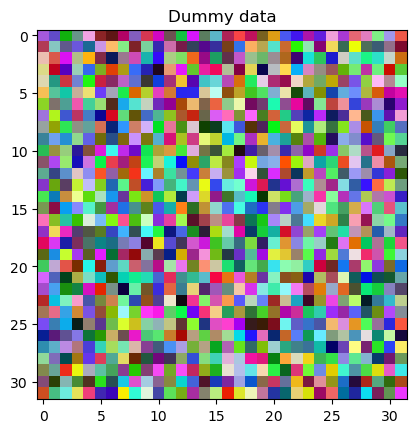

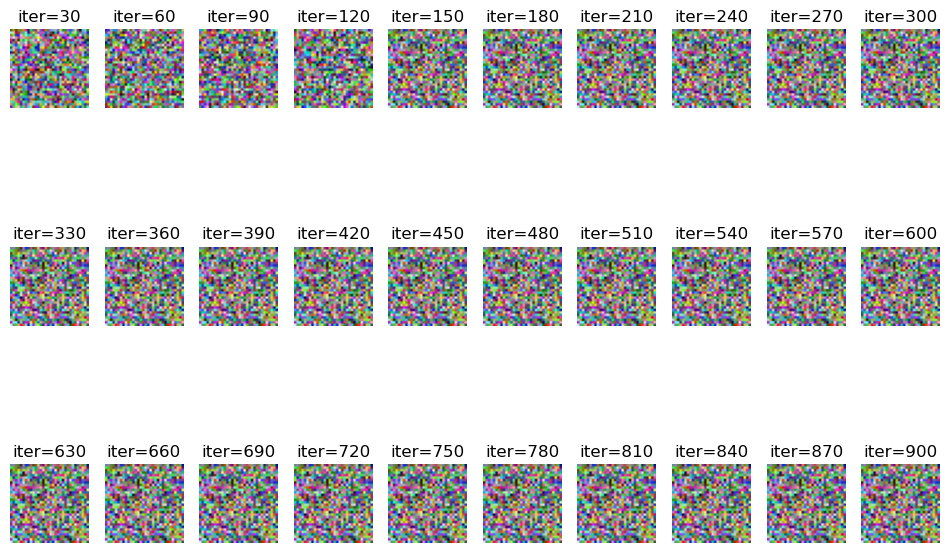

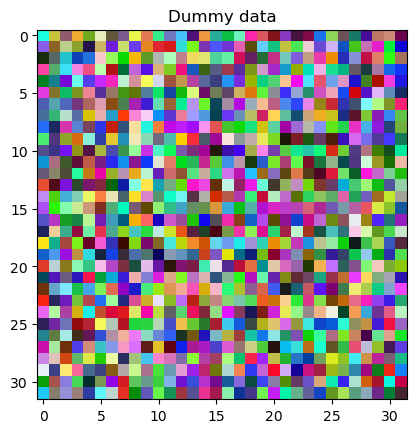

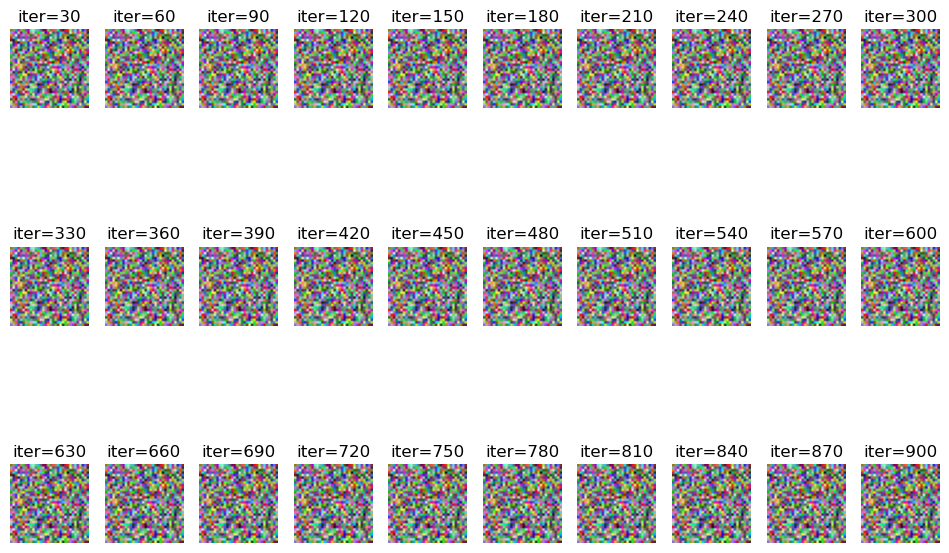

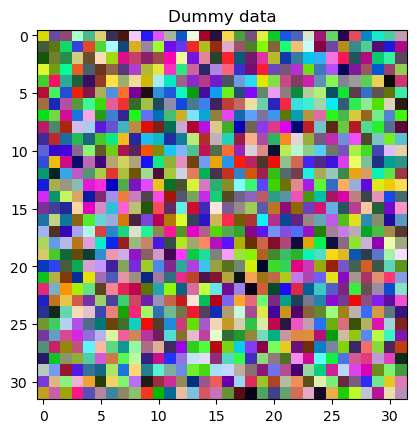

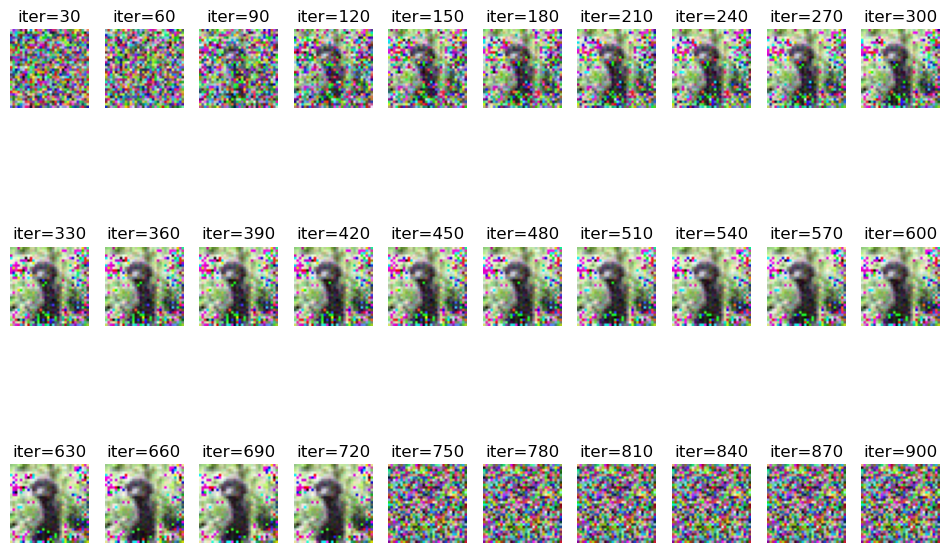

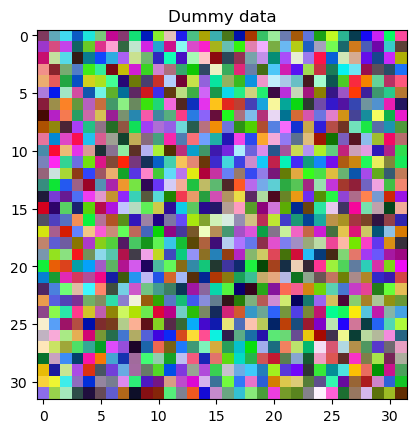

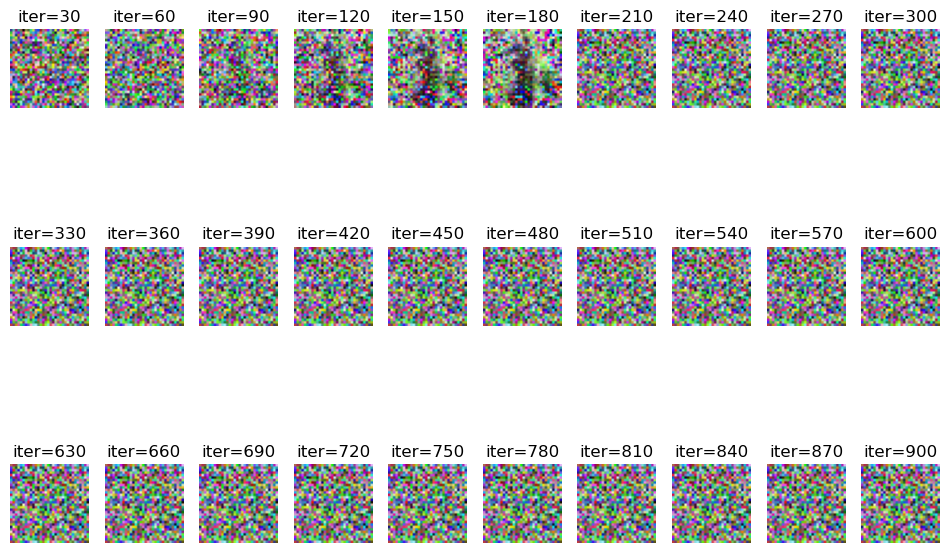

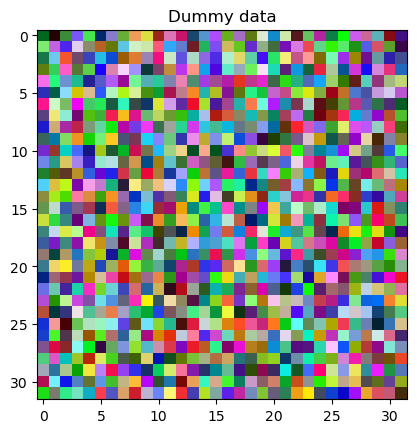

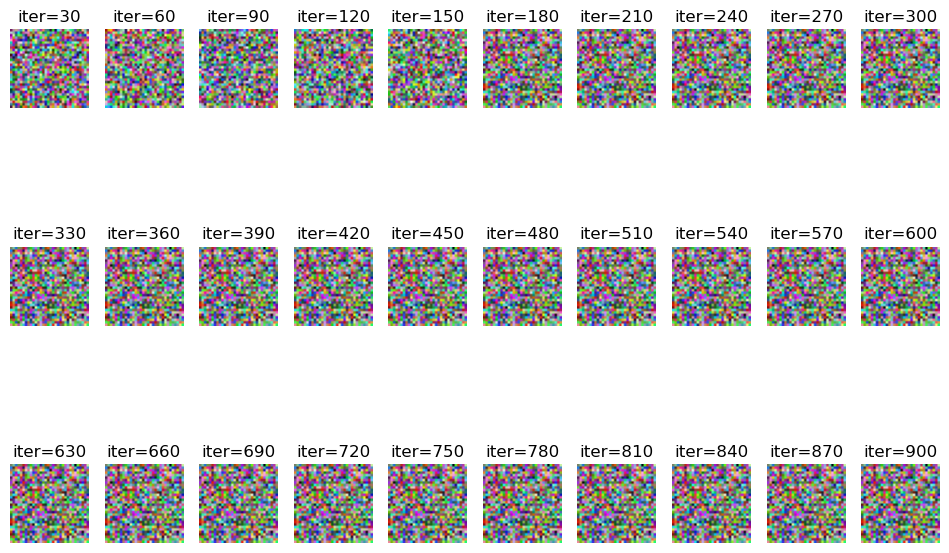

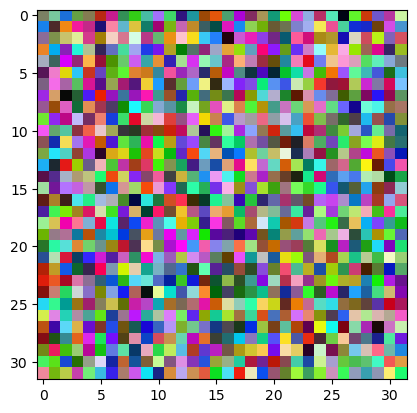

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__, torchvision.__version__)
for tid in range(10):
    interval = 30
    class_num = 10
    protected_layers = []  # No specific layers to protect initially
    dst = datasets.CIFAR10("~/.torch", download=True)
    tp = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])
    tt = transforms.ToPILImage()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:4"  # Changed to cuda:0 for general usage
    print("Running on %s" % device)

    def label_to_onehot(target, num_classes=class_num):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    class LeNet(nn.Module):
        def __init__(self):
            super(LeNet, self).__init__()
            act = nn.Sigmoid
            self.body = nn.Sequential(
                nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
            )
            self.fc = nn.Sequential(
                nn.Linear(768, class_num)
            )

        def forward(self, x):
            out = self.body(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
            return out

    net = LeNet().to(device)

    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    img_index = 55
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    def mask_gradients(dy_dx, exposure_ratio=1/3):
        flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
        total_params = len(flattened_grads)
        exposed_params = int(total_params * exposure_ratio)

        mask = torch.zeros(total_params, device=flattened_grads.device)
        mask[:exposed_params] = 1
        # mask = mask[torch.randperm(total_params)]

        masked_grads = []
        start = 0
        for g in dy_dx:
            numel = g.numel()
            g_flat = g.view(-1)
            masked_g_flat = g_flat * mask[start:start+numel]
            masked_grads.append(masked_g_flat.view_as(g))
            start += numel

        return tuple(masked_grads)

    dy_dx = mask_gradients(dy_dx)

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    losses = []
    for iters in range(30*interval):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            dummy_dy_dx = mask_gradients(dummy_dy_dx)

            grad_diff = 0
            grad_count = 0

            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            losses.append(grad_diff.item())
            return grad_diff

        optimizer.step(closure)
        if iters % interval == 0:
            print(f"{iters}, {losses[iters]}")
        history.append(tt(dummy_data[0].cpu()))

    plt.figure(figsize=(12, 8))
    for i in range(30):
        ite_num = i * interval + interval - 1
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[ite_num])
        plt.title("iter=%d" % (ite_num+1))
        plt.axis('off')

    filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) + '_' +'.png'
    plt.savefig(filename)

    plt.figure()
    loss = min(losses[0:interval * 30 - 1])
    idx = losses.index(loss)
    print(f"idx = {idx}, len = {len(losses)}")
    plt.imshow(history[idx])
    filename = 'single_' + filename
    plt.savefig(filename)

    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


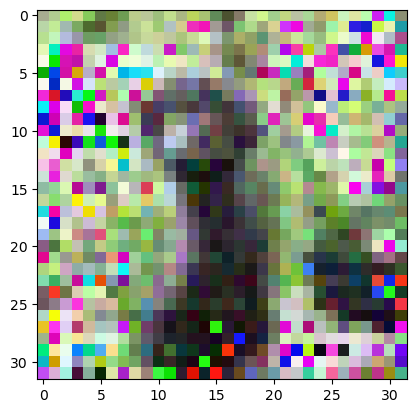

In [31]:
plt.imshow(history[209])
# plt.title("iter=%d" % (ite_num+1))
plt.show()

GT label is 2. 
Onehot label is 2.


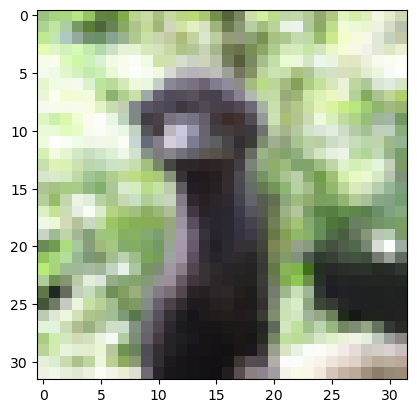

In [32]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
# plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())